In [28]:
!pip install seaborn scikit-learn opencv-python-headless


In [29]:
import os
import cv2 as cv
import numpy as np
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
from google.colab import files
import zipfile

In [32]:
uploaded = files.upload()

Saving PlantVillage.zip to PlantVillage (1).zip


In [33]:
zip_path = list(uploaded.keys())[0]  # take uploaded file name
extract_path = "/content/PlantVillage"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)

Dataset extracted to: /content/PlantVillage


In [34]:

def extract_mean_color(image):
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    mean_rgb = np.mean(image, axis=(0, 1))
    mean_hsv = np.mean(hsv, axis=(0, 1))
    return np.concatenate([mean_rgb, mean_hsv])  # 6 features

def extract_color_histogram(image):
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    hist_hue = cv.calcHist([hsv], [0], None, [32], [0, 180])  # Hue only
    hist_hue = cv.normalize(hist_hue, hist_hue).flatten()
    return hist_hue  # 32 features

def extract_color_moments(image):
    image = cv.resize(image, (128, 128))
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    color_moments = []
    for i in range(3):  # H, S, V
        channel = hsv[:, :, i].flatten()
        mean = np.mean(channel)
        std = np.std(channel)
        sk = skew(channel)
        color_moments.extend([mean, std, sk])
    return np.array(color_moments)  # 9 features

def extract_hsv_mean_only(image):
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    return np.mean(hsv, axis=(0, 1))  # 3 features

def extract_all_color_features(image):
    return np.concatenate([
        extract_mean_color(image),
        extract_color_histogram(image),
        extract_color_moments(image),
        extract_hsv_mean_only(image)
    ])

In [35]:
DATASET_PATH = extract_path

images = []
labels = []
image_extensions = ['.jpg', '.jpeg', '.png']

for class_name in os.listdir(DATASET_PATH):
    class_folder = os.path.join(DATASET_PATH, class_name)

    if not os.path.isdir(class_folder):
        continue

    # Traverse subclass folders
    for subclass_name in os.listdir(class_folder):
        subclass_folder = os.path.join(class_folder, subclass_name)

        if not os.path.isdir(subclass_folder):
            continue

        for file_name in os.listdir(subclass_folder):
            if not any(file_name.lower().endswith(ext) for ext in image_extensions):
                continue

            file_path = os.path.join(subclass_folder, file_name)
            img = cv.imread(file_path)

            if img is None:
                print(f"Could not read {file_path}")
                continue

            img_resized = cv.resize(img, (256, 256))
            images.append(img_resized)
            labels.append(subclass_name)

print(f"Loaded {len(images)} images from {len(set(labels))} classes.")


Loaded 20638 images from 15 classes.


In [36]:
features = [extract_all_color_features(img) for img in images]
X = np.array(features)

# Encode labels into integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

print("Feature matrix shape:", X.shape)
print("Number of classes:", len(label_encoder.classes_))

Feature matrix shape: (20638, 50)
Number of classes: 15


In [37]:

# ============================
# STEP 7: Train/Test Split
# ============================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [38]:

'''# ============================
# STEP 8: Train SVM
# ============================

model = SVC(kernel='rbf', C=10, gamma='scale')
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
'''
# STEP 8: Train SVM with GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'linear']
}

grid = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Accuracy:", grid.best_score_)

# best model from grid search
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test_scaled)


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.9378556794074268


In [ ]:
# STEP 9: Evaluation (with tuned model)
print("Best Parameters from tuning:", grid.best_params_) # if using GridSearchCV
print("Best Cross-Validation Accuracy:", grid.best_score_)
print("Test Accuracy:", best_model.score(X_test_scaled, y_test))
print()
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

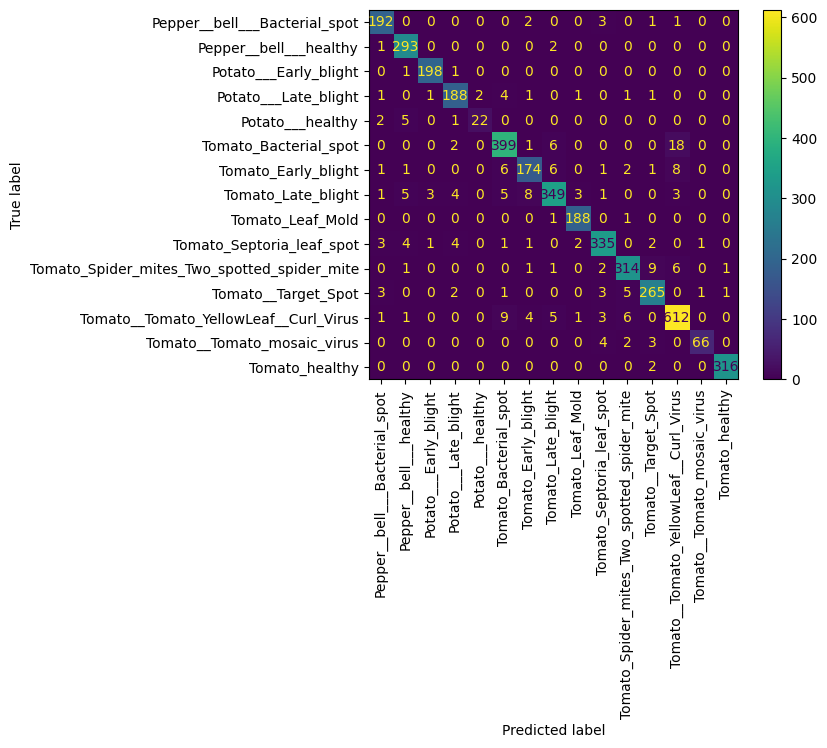

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation=90, cmap="viridis")
plt.show()


# ============================
# STEP 8: Train SVM with RandomizedSearchCV (faster than GridSearchCV)
# ============================
param_dist = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'linear']
}

random_search = RandomizedSearchCV(
    SVC(),
    param_distributions=param_dist,
    n_iter=5,   # only try 5 random combinations
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_scaled, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best CV Accuracy:", random_search.best_score_)

# best tuned model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
